# Tahoe Healthcare
- The goal of this case is exploratory data analysis to understand what factors are the biggest indicator or readmissions. This way, instead of rolling out 'Care Tracker' to every patient ( which costs `$1,200` per patient), only the groups of patients most at risk of being re-admitted will be enrolled into the Care Tracker program.
- The first section will be some basic exploratory data analysis to understand the makeup of the patient data.
- The second section will look into clustering from both a manegerial and statistical perspective.
- The third second will work on fitting different supervised marchine learning regression models (based on RMSE) to predict readmission.
- The fourth section will outline the most important variables to predict readmission, as well as recommendations to Tahoe Healthcare.

## Exploratory data analysis

In [267]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from model_testing import Model_Testing_Regression
from scipy.spatial.distance import euclidean
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from operator import itemgetter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
tahoe_df = pd.read_csv('Final Project Data_Case.csv')


In [4]:
tahoe_df.tail()

,﻿age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
4377,88,1,0,1,34,94,0
4378,98,0,0,1,51,136,0
4379,84,1,0,1,10,32,0
4380,67,1,1,1,10,73,0
4381,79,1,0,1,20,92,0


- Rename the columns to make them easier to work with


In [5]:
tahoe_df['age']=tahoe_df['﻿age']
tahoe_df['severity_score']=tahoe_df['severity score']
tahoe_df['comorbidity_score'] = tahoe_df['comorbidity score']
tahoe_df.drop(['﻿age','severity score','comorbidity score'],axis=1,inplace=True)

In [6]:
tahoe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 7 columns):
female               4382 non-null int64
flu_season           4382 non-null int64
ed_admit             4382 non-null int64
readmit30            4382 non-null int64
age                  4382 non-null int64
severity_score       4382 non-null int64
comorbidity_score    4382 non-null int64
dtypes: int64(7)
memory usage: 239.7 KB


In [7]:
# 4,382 patient records

In [8]:
tahoe_df.describe()

,female,flu_season,ed_admit,readmit30,age,severity_score,comorbidity_score
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,0.469192,0.408033,0.809220,0.227750,76.847330,22.353263,94.735509
std,0.499107,0.491525,0.392961,0.419428,7.904949,18.005320,57.145155
min,0.000000,0.000000,0.000000,0.000000,65.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,0.000000,70.000000,8.000000,51.000000
50%,0.000000,0.000000,1.000000,0.000000,76.000000,19.000000,86.000000
75%,1.000000,1.000000,1.000000,0.000000,82.000000,32.000000,131.000000
max,1.000000,1.000000,1.000000,1.000000,105.000000,112.000000,322.000000


- Age varies from 65 to 105
- Slightly more males
- More admits outside of flue season, 
- Majority are emergency room admits
- Most admits have fairly high severity score and comordibity score
- About 23% readmit after 30 days

In [9]:
tahoe_corr_matrix = tahoe_df.corr()
tahoe_corr_matrix

,female,flu_season,ed_admit,readmit30,age,severity_score,comorbidity_score
female,1.000000,0.014966,0.122485,0.042248,0.149257,0.095394,0.005320
flu_season,0.014966,1.000000,-0.012863,0.121551,-0.011575,0.003079,-0.012914
ed_admit,0.122485,-0.012863,1.000000,0.054564,0.139642,0.335556,0.030971
readmit30,0.042248,0.121551,0.054564,1.000000,0.102466,0.250942,0.383048
age,0.149257,-0.011575,0.139642,0.102466,1.000000,0.281042,0.161160
severity_score,0.095394,0.003079,0.335556,0.250942,0.281042,1.000000,0.196759
comorbidity_score,0.005320,-0.012914,0.030971,0.383048,0.161160,0.196759,1.000000


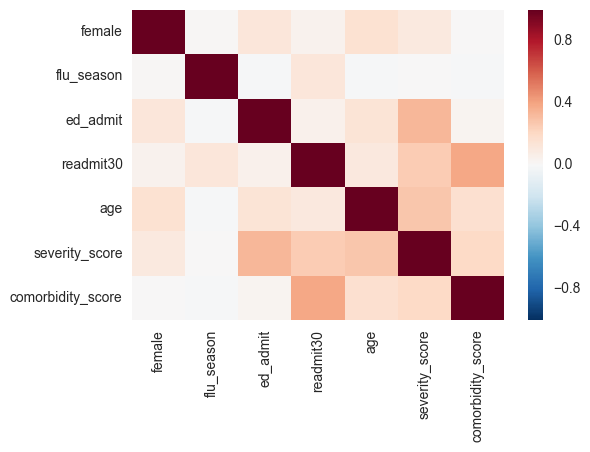

In [10]:
sns.heatmap(tahoe_corr_matrix);

- Interested in correlations with readmit30
    - High correlation with comorbidty score, severity score, and to a lesser extend flu season and age
- Next, plot the distributions of these variables

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


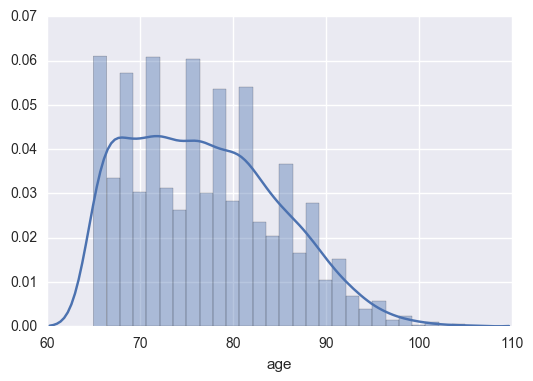

In [11]:
sns.distplot(tahoe_df.loc[:,'age']);

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


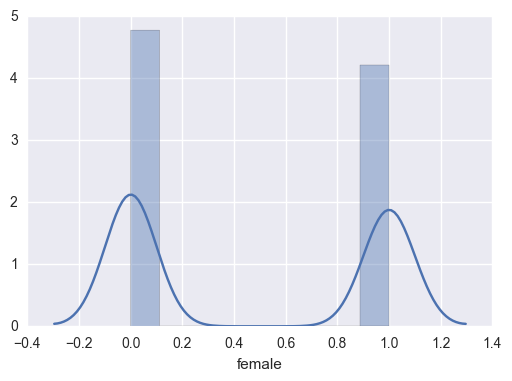

In [12]:
sns.distplot(tahoe_df.loc[:,'female']);

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


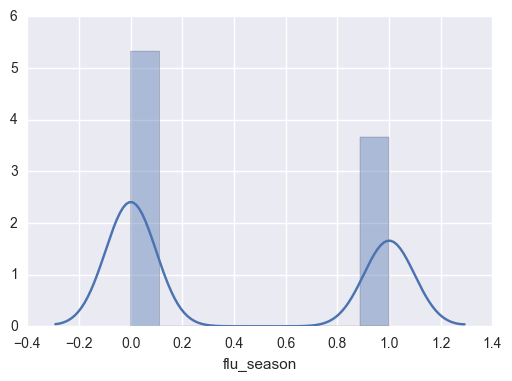

In [13]:
sns.distplot(tahoe_df.loc[:,'flu_season']);

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


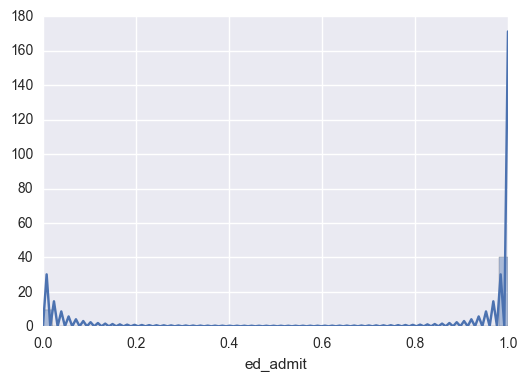

In [14]:
sns.distplot(tahoe_df.loc[:,'ed_admit']);

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


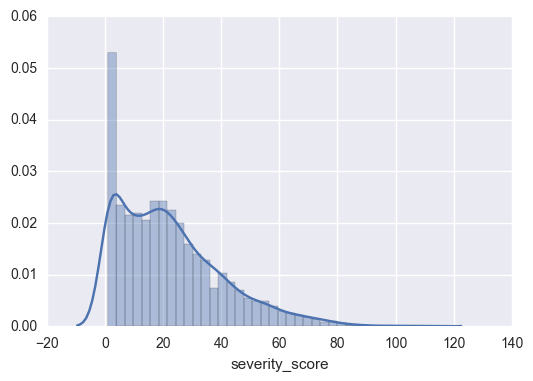

In [15]:
sns.distplot(tahoe_df.loc[:,'severity_score']);

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


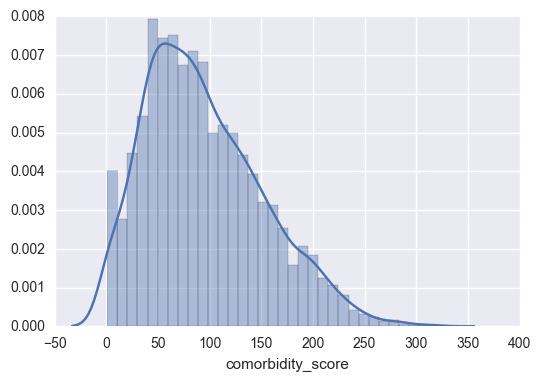

In [16]:
sns.distplot(tahoe_df.loc[:,'comorbidity_score']);

## Cluster the patients
- First, managerial clustering
    - Cluster on the percentiles of comorbidty score, severity score, and flu season. There are four quartiles for each of the first two varaibles (and two for the second for a total of 32 `bclusters
- Second, statistical clustering
    - K-means will be used on all of the varaibles to determine the optimal clustering strategy

In [17]:
tahoe_quartiles = tahoe_df.describe()

In [18]:
severity_score_quartiles = [i for i in tahoe_quartiles['severity_score'].iloc[4:7]]
severity_score_quartiles.append(33) ## to account for last quartile
comorbidity_score_quartiles = [i for i in tahoe_quartiles['comorbidity_score'].iloc[4:7]]
comorbidity_score_quartiles.append(132)## to account for last quartile
flu_season=[.1,.9] # greater than or less than this (i.e. 0 or 1)

In [145]:
tahoe_quartiles.loc[:,('severity_score','comorbidity_score','flu_season')]

,severity_score,comorbidity_score,flu_season
count,4382.000000,4382.000000,4382.000000
mean,22.353263,94.735509,0.408033
std,18.005320,57.145155,0.491525
min,1.000000,1.000000,0.000000
25%,8.000000,51.000000,0.000000
50%,19.000000,86.000000,0.000000
75%,32.000000,131.000000,1.000000
max,112.000000,322.000000,1.000000


In [146]:
tahoe_df.head()

,female,flu_season,ed_admit,readmit30,age,severity_score,comorbidity_score,severity_quantile,comorbidity_quantile
0,1,1,1,0,100,38,112,3,2
1,1,0,1,1,83,8,109,0,2
2,0,1,0,0,74,1,80,0,1
3,1,1,1,0,66,25,4,2,0
4,1,1,1,0,68,25,32,2,0


In [147]:
tahoe_df['severity_quantile'] = pd.qcut(tahoe_df['severity_score'], 4, labels=False)
tahoe_df['comorbidity_quantile'] = pd.qcut(tahoe_df['comorbidity_score'], 4, labels=False)


In [148]:
flu_season

[0.1, 0.9]

In [149]:
severity_score_quartiles

[8.0, 19.0, 32.0, 33]

In [150]:
comorbidity_score_quartiles 

[51.0, 86.0, 131.0, 132]

In [151]:
[ i for i in range(2)]

[0, 1]

In [152]:
def assign_managerial_clusters(input_dataframe):
    """Assign managerial clusters given the severity socre, comorbidty score, and fluseason indicator.
    This assumes that the input dataframe already has indicators for the bins for each columns"""
    count = 1
    df = input_dataframe.copy()
    list_of_df = []
    count = 0
    df['managerial_cluster']=np.nan
    final_df = pd.DataFrame(columns = ['female', 'flu_season', 'ed_admit', 'readmit30', 'age',
       'severity_score', 'comorbidity_score', 'severity_quantile',
       'comorbidity_quantile','managerial_cluster'])
    count = 0
    row_of_assignments = []
    cluster_assignments =defaultdict(int)
    for comordibty_q in range(4):
        for severity_q in range(4):
            for flu_h in range(2):
                cluster =  df[(df['comorbidity_quantile'] == comordibty_q) & \
                        (df['severity_quantile'] == severity_q) &\
                        (df['flu_season'] == flu_h)]
                cluster['managerial_cluster'] = count
                final_df = pd.concat([final_df,cluster]) ## add to a final DF
                cluster_assignments[comordibty_q,severity_q,flu_h]=count

                count +=1      
    return final_df,cluster_assignments
        
            
    
    
    
                

In [153]:
tahoe_mang_cluster_df, custer_assignments = assign_managerial_clusters(tahoe_df)

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [154]:
tahoe_mang_cluster_df.managerial_cluster.describe()

count    4382.000000
mean       15.257417
std         9.637573
min         0.000000
25%         7.000000
50%        15.000000
75%        23.000000
max        31.000000
Name: managerial_cluster, dtype: float64

- Next, determine the probability of re-admittance per managerial cluster

In [155]:
## total number of readmission per managerial cluster
readmission_per_cluster = tahoe_mang_cluster_df.groupby(['managerial_cluster'])['readmit30'].sum().reset_index()

In [156]:
# divide by the total number to get the probability of re-admission per cluster

patients_per_cluster = tahoe_mang_cluster_df.groupby(['managerial_cluster'])['readmit30'].count().reset_index()


In [157]:
## probability of readmission per cluster
probability_readmission_per_cluster = (readmission_per_cluster/patients_per_cluster ).reset_index()
#sorted_probability_readmission_per_cluster = probability_readmission_per_cluster.sort_values(ascending=False).reset_index()
probability_readmission_per_cluster['probability_of_readmit'] =probability_readmission_per_cluster['readmit30'] 

In [158]:
probability_readmission_per_cluster['patients_per_cluster']=patients_per_cluster['readmit30']
probability_readmission_per_cluster['readmit_per_cluster'] = readmission_per_cluster['readmit30']

In [159]:
# sort by top readmit clusters
probability_readmission_per_cluster.sort_values('probability_of_readmit',ascending=False,inplace=True)

In [160]:
### add in the probability of readmit with caretracker (lowers it by 40%)
probability_readmission_per_cluster['probability_readmit_caretracker'] = \
probability_readmission_per_cluster.probability_of_readmit*.6

In [161]:
probability_readmission_per_cluster

,index,managerial_cluster,readmit30,probability_of_readmit,patients_per_cluster,readmit_per_cluster,probability_readmit_caretracker
31,31,1.0,0.717791,0.717791,163,117.0,0.430675
29,29,1.0,0.543103,0.543103,116,63.0,0.325862
25,25,1.0,0.533333,0.533333,75,40.0,0.320000
27,27,1.0,0.511628,0.511628,86,44.0,0.306977
30,30,1.0,0.502041,0.502041,245,123.0,0.301224
28,28,1.0,0.393939,0.393939,165,65.0,0.236364
23,23,1.0,0.367347,0.367347,98,36.0,0.220408
22,22,1.0,0.348684,0.348684,152,53.0,0.209211
21,21,1.0,0.324786,0.324786,117,38.0,0.194872
15,15,1.0,0.298969,0.298969,97,29.0,0.179381


- Next, determine the cost of adding Care Tracker per cluster per person in each cluster


In [167]:
def find_minimum_cost(dataframe_input,cost_of_readmit=8000,cost_of_caretracker=1200):
    """find the minimum combination between using the caretracker for each person in a cluster, or the cost
    of readmission $8k per person in that cluter.
    
    The formula is  The Cost of readmittance * Number of patients who have be readmitted  , compared to
    
    The probability of readmittance given that a patient is using care tracker, 
    times the number of patients in that cluster, time the cost of readmittance, plus the cost of care tracker times
    the number of patients in that cluster
    """
    dataframe_i = dataframe_input.copy()
    list_of_options = []
    min_cost_per_option = []
    alternative_cost = []
    
    for idx, row in dataframe_i.iterrows():
        if (row['probability_readmit_caretracker'] *row['patients_per_cluster'] * cost_of_readmit + \
            cost_of_caretracker *row['patients_per_cluster'])   \
            < (cost_of_readmit *row['readmit_per_cluster']):
            
            list_of_options.append(1) ## assign to caretracker program
            min_cost_per_option.append(row['probability_readmit_caretracker']\
                                       *row['patients_per_cluster'] * cost_of_readmit + \
                                        cost_of_caretracker *row['patients_per_cluster'])
            alternative_cost.append(cost_of_readmit *row['readmit_per_cluster'])
        else:
            list_of_options.append(0) ## don't assign to caretracker program
            min_cost_per_option.append(cost_of_readmit *row['readmit_per_cluster'])
            alternative_cost.append(row['probability_readmit_caretracker']\
                                       *row['patients_per_cluster'] * cost_of_readmit + \
                                        cost_of_caretracker *row['patients_per_cluster'])
        
    dataframe_i['min_cost']=min_cost_per_option
    dataframe_i['option']=list_of_options # 1 = assign to caretracker 0 = don't assign to caretracker
    dataframe_i['alternative_cost'] = alternative_cost
    return dataframe_i     
    
    

In [169]:
min_cost_tahoe_prob_df = find_minimum_cost(probability_readmission_per_cluster)

In [170]:
min_cost_tahoe_prob_df['care_tracker_cost_cluster'] = \
    min_cost_tahoe_prob_df['patients_per_cluster']*1200 + \
    min_cost_tahoe_prob_df['probability_readmit_caretracker']*min_cost_tahoe_prob_df['patients_per_cluster']*8000

min_cost_tahoe_prob_df['readmit_cost_cluster'] = \
    min_cost_tahoe_prob_df['readmit_per_cluster']*8000 

In [171]:
min_cost_tahoe_prob_df[min_cost_tahoe_prob_df.option==1]

,index,managerial_cluster,readmit30,probability_of_readmit,patients_per_cluster,readmit_per_cluster,probability_readmit_caretracker,min_cost,option,alternative_cost,care_tracker_cost_cluster,readmit_cost_cluster
31,31,1.0,0.717791,0.717791,163,117.0,0.430675,757200.0,1,936000.0,757200.0,936000.0
29,29,1.0,0.543103,0.543103,116,63.0,0.325862,441600.0,1,504000.0,441600.0,504000.0
25,25,1.0,0.533333,0.533333,75,40.0,0.320000,282000.0,1,320000.0,282000.0,320000.0
27,27,1.0,0.511628,0.511628,86,44.0,0.306977,314400.0,1,352000.0,314400.0,352000.0
30,30,1.0,0.502041,0.502041,245,123.0,0.301224,884400.0,1,984000.0,884400.0,984000.0
28,28,1.0,0.393939,0.393939,165,65.0,0.236364,510000.0,1,520000.0,510000.0,520000.0


In [172]:
# Find the savings per cluster

In [173]:
savings_over_readmit= sum(min_cost_tahoe_prob_df.readmit_cost_cluster -min_cost_tahoe_prob_df.min_cost )
savings_over_care_tracker = sum(min_cost_tahoe_prob_df.care_tracker_cost_cluster-min_cost_tahoe_prob_df.min_cost )

In [174]:
print("Tahoe will save {} compared to not assigning anyone to care tracker".format(savings_over_readmit))
print("Tahoe will save {} compared to assigning everyone to care tracker".format(savings_over_care_tracker))
baseline_readmittance =  sum(min_cost_tahoe_prob_df.readmit_per_cluster)/sum(min_cost_tahoe_prob_df.patients_per_cluster)
baseline_noreadmittance = 1-baseline_readmittance
print("The baseline probability of re-admittance is {:.2%}".format(
        sum(min_cost_tahoe_prob_df.readmit_per_cluster)/sum(min_cost_tahoe_prob_df.patients_per_cluster)))
print("The baseline of no readmittance is {:.2%}".format(baseline_noreadmittance))

Tahoe will save 426400.0000000002 compared to not assigning anyone to care tracker
Tahoe will save 2491200.0 compared to assigning everyone to care tracker
The baseline probability of re-admittance is 22.77%
The baseline of no readmittance is 77.23%


### Following the advice from managerial clustering on which segments to assign to care tracker, we would save `$2,491,200` compared to assigning everyone to  care tracker and will save `$426,000` compared to not assigning anyone to care tracker.
- This is assuming our sample of patients represents the entire population of patients
- Managerial is typically easier for businesses to implement compared to an algorithm
- However, some risks inlude the fact the this is a static model that does not evolve over time.


> We should assign segments, 31,29,25,27,30, and 28 to care tracker
- 31: comorbidity_score above 131, severity_score above 32, in flu season
- 29: comorbidity_score above 131, severity_score 19-32, in flu season
- 25: comorbidity_score above 131, severity_score below 8, in flu season
- 27: comorbidity_score above 131, severity_score 8 to 19, in flu season
- 30: comorbidity_score above 131, severity_score above 32, not in flu season
- 28: comorbidity_score above 131, severity_score 19-32, not in flu season

# Next, investigate statistical clustering and machine learning to determine the best option.
- Start with k-means
    - To find the ideal number of clusters, run a silhouette score model on different cluster sizes
    - Don't cluster on readmit rate, we don't know this when a patient comes in
- Then, investigate a couple supervised classification models

In [175]:
def euclidean_distance(a,b):
    """Expects numpy array and returns the euclidan distance between them"""
    return sqrt(sum((a-b)**2))

In [176]:
clustering_df = tahoe_df.iloc[:,:5]
clustering_df.head()

,female,flu_season,ed_admit,readmit30,age
0,1,1,1,0,100
1,1,0,1,1,83
2,0,1,0,0,74
3,1,1,1,0,66
4,1,1,1,0,68


In [433]:

def sample_silhouette_score(dataframe_input,max_cluster_size=100):
    """Run a three fold CV on 10,000 samples from the dataframe to determine the ideal number of clusters.
    Output is the ideal number of clusters of 3 CV folds with 10k samples."""
    silhouette_score_l = []
    predicted_labels = defaultdict(list)
    for clusters in range(2,max_cluster_size):
        knn_classifier = KMeans(clusters)
        silhouette_scores_for_this_cluster = []
        fit_knn = knn_classifier.fit(dataframe_input)
        predicted_labels[clusters]=fit_knn.labels_
        predicted_lab = fit_knn.labels_
        silhouette_score_l.append(silhouette_score(X=dataframe_input,labels=predicted_lab))
        print('Finished iteration {}'.format(clusters))
    number_of_clusters = [i for i in range(2,max_cluster_size)]
    plt.plot([i for i in range(2,max_cluster_size)],silhouette_score_l)
    plt.title('Ideal Number of Clusters')
    plt.ylabel('Silhouette score')
    plt.xlabel('Number of clusters')
    print('The best number of clusters is {}'.format(number_of_clusters[np.argmax(np.array(silhouette_score_l))]))
    return predicted_labels[number_of_clusters[np.argmax(np.array(silhouette_score_l))]]
    

Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
Finished iteration 39
Finished iteration 40
Finished iteration 41
Finished iteration 42
Finished iteration 43
Finished iteration 44
Finished iteration 45
Finished iteration 46
Finished iteration

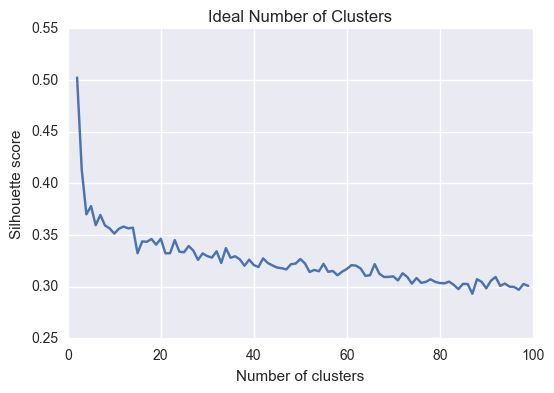

In [434]:
clustered_labels = sample_silhouette_score(clustering_df)

##### The ideal number of clusters is two, which means that there is not a lot of difference in the people being clustered. We will skip the clustering here and move onto a machine learning algorithm
- Test random forest
- Logistic regression


##### To deal with the class imbalance, create stratified sampling methods to form a balanced class

In [34]:
admitted_df =tahoe_df[tahoe_df.readmit30==1]


In [35]:
not_admitted_df = tahoe_df[tahoe_df.readmit30==0]

In [36]:
len(admitted_df)

998

### Take sample s of 998 from the not_admitted_df to create balanced classes
- Baseline is 50/50 is a balanced class

In [37]:
sample_1 = not_admitted_df.sample(998)

In [38]:
balanced_df_1 =pd.concat([sample_1,admitted_df])

In [39]:
balanced_df_1.tail()

,female,flu_season,ed_admit,readmit30,age,severity_score,comorbidity_score,severity_quantile,comorbidity_quantile
4357,1,1,1,1,88,42,44,3,0
4364,0,0,1,1,73,48,213,3,3
4366,1,1,1,1,72,27,128,2,2
4370,0,0,1,1,83,48,172,3,3
4373,1,1,1,1,67,13,45,1,0


In [40]:
# not balanced
tahoe_X = tahoe_df.loc[:,('female', 'flu_season', 'ed_admit',  'age',\
       'severity_score', 'comorbidity_score')]
tahoe_y = tahoe_df.loc[:,'readmit30']
tahoe_X_labels = ['female', 'flu_season', 'ed_admit', 'age',
       'severity_score', 'comorbidity_score']
tahoe_y_labels = 'readmit30'

In [41]:
tahoe_bal_X = balanced_df_1.loc[:,('female', 'flu_season', 'ed_admit',  'age',\
       'severity_score', 'comorbidity_score')]
tahoe_bal_y = balanced_df_1.loc[:,'readmit30']
tahoe_X_labels = ['female', 'flu_season', 'ed_admit', 'age',
       'severity_score', 'comorbidity_score']
tahoe_y_labels = 'readmit30'

In [42]:
# Create RF model
best_rf_model = RandomForestClassifier(1000)

In [43]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(tahoe_X,tahoe_y,random_state=42)

In [45]:
# Best random forest
best_rf_model.fit( X_train_rf, y_train_rf)


best_rf_rmse =euclidean(y_test_rf,best_rf_model.predict(X_test_rf))/sqrt(len(y_test_rf))
print('Best RF RMSE :{}'.format(best_rf_rmse ))
print()
best_rf_r2 =abs(r2_score(y_test_rf,best_rf_model.predict(X_test_rf)))
print('Best RF R^2 score :{:.2%}'.format(best_rf_r2))
print()
rf_accuracy_score = accuracy_score(y_test_rf,best_rf_model.predict(X_test_rf))
print("Best accuracy score {:.2%}".format(rf_accuracy_score))
feature_weights_rf = best_rf_model.feature_importances_[np.argsort(best_rf_model.feature_importances_)[::-1]]
# print(regression_tahoe_readmit.x_labels) 
feature_names_rf = np.array(tahoe_X.columns)[np.argsort(best_rf_model.feature_importances_)[::-1]]

print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_rf_model.feature_importances_[np.argsort(best_rf_model.feature_importances_)[::-1]],\
                        np.array(tahoe_X.columns)[np.argsort(best_rf_model.feature_importances_)[::-1]])])

Best RF RMSE :0.47855469754265917

Best RF R^2 score :24.60%

Best accuracy score 77.10%
[('Feature:', 'comorbidity_score', 'Importance:', 0.43607552236893687), ('Feature:', 'severity_score', 'Importance:', 0.27314003268246612), ('Feature:', 'age', 'Importance:', 0.2179161600954134), ('Feature:', 'flu_season', 'Importance:', 0.029277844544063902), ('Feature:', 'female', 'Importance:', 0.026316135160830638), ('Feature:', 'ed_admit', 'Importance:', 0.01727430514828928)]


In [81]:
fpr_rf,tpr_rf,threshold_rf = roc_curve(y_test_rf, best_rf_model.predict(X_test_rf))

In [83]:
auc_rf = auc(fpr_rf,tpr_rf)

In [47]:
threshold_rf 

array([2, 1, 0])

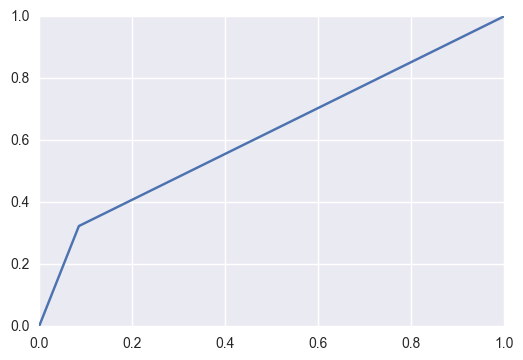

In [49]:
plt.plot(fpr_rf,tpr_rf)

## Next, try logistic classification

In [50]:

logistic_model = LogisticRegression(penalty='l2')

In [51]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(tahoe_X,tahoe_y,random_state=42)

In [52]:
logistic_model.fit(X_train_log,y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
best_logistic_rmse =euclidean(y_test_log,logistic_model.predict(X_test_log))/sqrt(len(y_test_log))
print('Best logistic RMSE :{}'.format(best_logistic_rmse))
print()
best_logistic_r2 = abs(r2_score(y_test_log,logistic_model.predict(X_test_log)))
print('Best logistic R^2 score :{:.2%}'.format(best_logistic_r2))
print()
accuracy_score_log = accuracy_score(y_test_log,logistic_model.predict(X_test_log))
print("Best logistic accuracy {:.1%}".format(accuracy_score_log))

feature_weights_logistic = abs(logistic_model.coef_)[0][np.argsort(abs(logistic_model.coef_))[0][::-1]]
feature_names_logistic = np.array(tahoe_X.columns)[np.argsort(logistic_model.coef_)[0][::-1]]

print([('Feature:',i,'Importance:',f)\
    for f,i in zip(feature_weights_logistic ,\
                        feature_names_logistic)])

Best logistic RMSE :0.45409732388778046

Best logistic R^2 score :12.19%

Best logistic accuracy 79.4%
[('Feature:', 'flu_season', 'Importance:', 0.70175268891372855), ('Feature:', 'female', 'Importance:', 0.228045760434576), ('Feature:', 'severity_score', 'Importance:', 0.11564181427083099), ('Feature:', 'comorbidity_score', 'Importance:', 0.027685577324908353), ('Feature:', 'age', 'Importance:', 0.015867558841762584), ('Feature:', 'ed_admit', 'Importance:', 0.0095862704273493513)]


In [54]:
fpr_log,tpr_log,threshold = roc_curve(y_test_log, logistic_model.predict(X_test_log))

In [84]:
auc_log = auc(fpr_log,tpr_log)

# Try gradient boosting as well

In [57]:
GBoostModel = GradientBoostingClassifier(max_depth=2,n_estimators=1000)

In [58]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(tahoe_X,tahoe_y,random_state=42)

In [59]:
GBoostModel.fit(X_train_gb,y_train_gb)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [60]:
best_gb_rmse =euclidean(y_test_gb,GBoostModel.predict(X_test_gb))/sqrt(len(y_test_gb))
print('Best gb RMSE :{}'.format(best_gb_rmse))
print()
best_gb_r2 = abs(r2_score(y_test_gb,GBoostModel.predict(X_test_gb)))
print('Best gb R^2 score :{:.2%}'.format(best_gb_r2))
print()
accuracy_score_gb = accuracy_score(y_test_gb,GBoostModel.predict(X_test_gb))
print("Best gb accuracy {:.1%}".format(accuracy_score_gb))

feature_weights_gb = GBoostModel.feature_importances_[np.argsort(GBoostModel.feature_importances_)[::-1]]
feature_names_gb = np.array(tahoe_X.columns)[np.argsort(GBoostModel.feature_importances_)[::-1]]

print([('Feature:',i,'Importance:',f)\
    for f,i in zip(feature_weights_gb ,\
                        feature_names_gb)])

Best gb RMSE :0.46107617686876035

Best gb R^2 score :15.67%

Best gb accuracy 78.7%
[('Feature:', 'comorbidity_score', 'Importance:', 0.4958466243170474), ('Feature:', 'severity_score', 'Importance:', 0.25677060850740036), ('Feature:', 'age', 'Importance:', 0.19349876063105856), ('Feature:', 'female', 'Importance:', 0.022446611828486639), ('Feature:', 'ed_admit', 'Importance:', 0.018907262087995848), ('Feature:', 'flu_season', 'Importance:', 0.012530132628011099)]


In [61]:
fpr_gb,tpr_gb,threshold = roc_curve(y_test_gb, GBoostModel.predict(X_test_gb))

In [86]:
auc_gb= auc(fpr_gb,tpr_gb)

# Finally, use support vector machines to predict readmission
- I did not include these results as the model performed very poorly

In [66]:
svm_model = SVC()

In [67]:
params_svm ={'C':[i for i in np.linspace(.1,20,50)]}

In [68]:
best_svm_model = GridSearchCV(svm_model,params_svm)

In [69]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(tahoe_X,tahoe_y,random_state=42)

In [70]:
print('hi')

hi


In [92]:
svm_model = best_svm_model.fit(X_train_svm,y_train_svm)

In [93]:
best_svm_rmse =euclidean(y_test_svm,svm_model.predict(X_test_svm))/sqrt(len(y_test_svm))
print('Best svm RMSE :{}'.format(best_svm_rmse))
print()
best_svm_r2 = abs(r2_score(y_test_svm,svm_model.predict(X_test_svm)))
print('Best svm R^2 score :{:.2%}'.format(best_svm_r2))
print()
accuracy_score_svm = accuracy_score(y_test_svm,svm_model.predict(X_test_svm))
print("Best svm accuracy {:.1%}".format(accuracy_score_svm))

#feature_weights_svm = GBoostModel.feature_importances_[np.argsort(GBoostModel.feature_importances_)[::-1]]
#feature_names_svm = np.array(tahoe_X.columns)[np.argsort(GBoostModel.feature_importances_)[::-1]]

#print([('Feature:',i,'Importance:',f)\
#    for f,i in zip(feature_weights_gb ,\
#                        feature_names_gb)])

Best svm RMSE :0.4926466582927436

Best svm R^2 score :32.05%

Best svm accuracy 75.7%


In [94]:
fpr_svm,tpr_svm,threshold_svm = roc_curve(y_test_svm,best_svm_model.predict(X_test_svm))

In [95]:
auc_svm = auc(fpr_svm,tpr_svm)

In [96]:
best_svm_model.predict(X_test_svm)

array([0, 0, 0, ..., 0, 0, 0])

In [104]:
print("The area under the curve for logistic {}, random forest {}, gradient boosting {}".format(
    auc_log,auc_rf,auc_gb))

The area under the curve for logistic 0.6301114231361535, random forest 0.6188830510009965, gradient boosting 0.6284491348854062


In [119]:
baseline_x = [ i for i in np.linspace(0,1,100)]
baseline_y = [ i for i in np.linspace(0,1,100)]

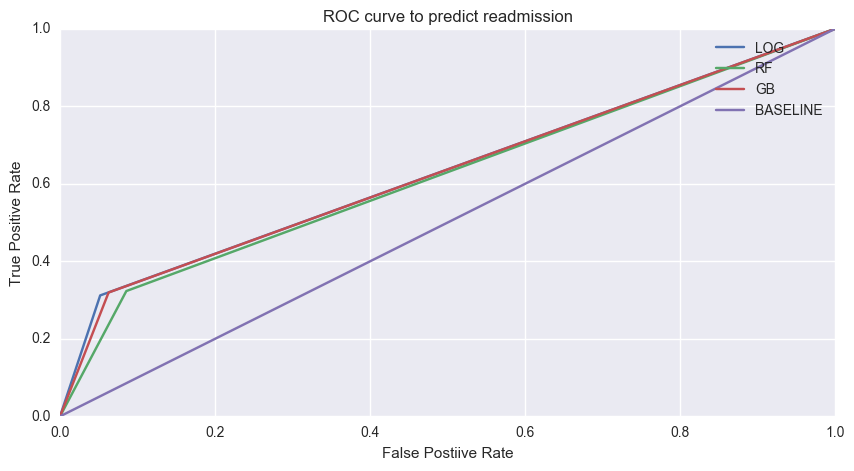

In [120]:
plt.figure(figsize=(10,5))
plt.plot(fpr_log,tpr_log, label='LOG')
plt.plot(fpr_rf,tpr_rf, label = 'RF')
plt.plot(fpr_gb,tpr_gb,label='GB')
plt.plot(baseline_x,baseline_y,label='BASELINE')
plt.title("ROC curve to predict readmission")
plt.ylabel("True Positive Rate")
plt.xlabel("False Postiive Rate")
plt.legend()

- Based upon this, use the Logistic Classification model
- Run each row through the model, and generate a probability of readmittance
- From this probability, determine where the threshold is to minimize cost


In [121]:
## only 465 positive cases
sum(logistic_model.predict(tahoe_X))

465

In [123]:
# almost one thousand positive in reality
sum(tahoe_y)


998

### Create a confusion matrix to understand th tp,fp,tn,fn for logistic regression

In [126]:
## 00 is true negatives
## false negative 10
# true positive 1,1
# false postiive 0,1
log_confusion_matrix = confusion_matrix(tahoe_y , logistic_model.predict(tahoe_X))

In [132]:
log_confusion_matrix 

array([[3228,  156],
       [ 689,  309]])

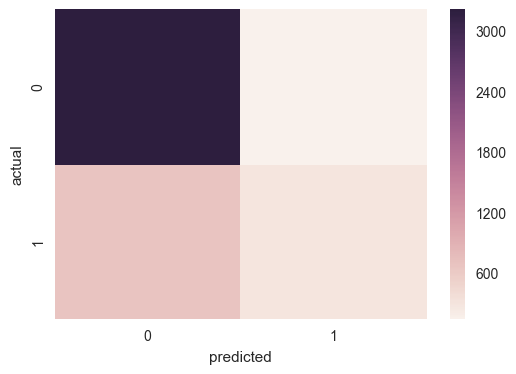

In [135]:
sns.heatmap(log_confusion_matrix);
plt.xlabel("predicted")
plt.ylabel("actual")

- Lot of True Negatives (0,0)
- Also, a lot of false negatives (cases where the person was readmitted but we perdicted that there were not going to be readmitted. This means we are conservative in our guessing readmittance.
    - Adjust threshold to reduce the false negatives
 

In [138]:
logsitic_predictions_df['prob_readmit']=prob_readmit 
logsitic_predictions_df['prob_noreadmit']=prob_noreadmit


In [178]:
prob_readmit_per_managerial_cluster = min_cost_tahoe_prob_df.loc[:,('managerial_cluster',"probability_of_readmit")]

In [179]:
prob_readmit_per_managerial_cluster .head()

,managerial_cluster,probability_of_readmit
31,1.0,0.717791
29,1.0,0.543103
25,1.0,0.533333
27,1.0,0.511628
30,1.0,0.502041


## Next, combine this probability or readmit from logistic, with the probability of readmit from the managerial clusters

In [199]:
combo_df = tahoe_mang_cluster_df.join(prob_readmit_per_managerial_cluster,on='managerial_cluster',lsuffix='m_clust')

In [200]:
combo_df.drop('managerial_clusterm_clust',axis=1,inplace=True)


In [201]:
combo_df.drop('managerial_cluster',axis=1,inplace=True)

In [223]:
logistic_model.classes_

array([0, 1])

In [222]:
logistic_model.predict_proba(combo_df.loc[:,('female','flu_season','ed_admit',
                                    'age','severity_score','comorbidity_score')])

array([[ 0.97075554,  0.02924446],
       [ 0.9646931 ,  0.0353069 ],
       [ 0.96325468,  0.03674532],
       ..., 
       [ 0.51075167,  0.48924833],
       [ 0.11627347,  0.88372653],
       [ 0.21846058,  0.78153942]])

In [202]:
prob_noreadmit, prob_readmit = zip(*logistic_model.predict_proba(combo_df.loc[:,('female','flu_season','ed_admit',
                                    'age','severity_score','comorbidity_score')]))

In [312]:
combo_df['prob_readmit_logistic']=prob_readmit 
combo_df['prob_noreadmit_logistic']=prob_noreadmit
combo_df['logistic_prediction']=logistic_model.predict(combo_df.loc[:,('female','flu_season','ed_admit',
                                    'age','severity_score','comorbidity_score')])


In [233]:
combo_df[combo_df.prob_readmit_logistic>.90]

,female,flu_season,ed_admit,readmit30,age,severity_score,comorbidity_score,severity_quantile,comorbidity_quantile,probability_of_readmit,prob_readmit_logistic,prob_noreadmit_logistic
2909,1.0,1.0,1.0,1.0,70.0,20.0,315.0,2.0,3.0,0.543103,0.916274,0.083726
1411,1.0,0.0,1.0,1.0,86.0,75.0,289.0,3.0,3.0,0.502041,0.933874,0.066126
2519,0.0,0.0,1.0,1.0,76.0,46.0,322.0,3.0,3.0,0.502041,0.912835,0.087165
1416,0.0,1.0,1.0,1.0,97.0,55.0,293.0,3.0,3.0,0.717791,0.933280,0.066720
1876,1.0,1.0,1.0,1.0,71.0,69.0,255.0,3.0,3.0,0.717791,0.942008,0.057992
2163,1.0,1.0,1.0,1.0,65.0,56.0,238.0,3.0,3.0,0.717791,0.901639,0.098361
3208,1.0,1.0,1.0,1.0,85.0,47.0,283.0,3.0,3.0,0.717791,0.923347,0.076653


### Current threshold is at .50, find the number that maximizes the number of true positives and true negatives (and minimizes cost)
- This will help compensate for the uneven number of people in each case


In [300]:
def find_threshold(dataframe_i,caretracker_cost=1200,readmit_cost=8000):
    """Find the best threshold that minimizes cost for logistic classification.
    
    The formula is  The Cost of readmittance * Number of patients who have be readmitted  , compared to
    
    The probability of readmittance given that a patient is using care tracker, 
    times the number of patients in that cluster, time the cost of readmittance, plus the cost of care tracker times
    the number of patients in that cluster
    """
    
    dataframe_i = dataframe_i.copy()
    list_of_options = []
    min_cost_per_option = []
    alternative_cost = []
    threshold_cost = defaultdict(int)
    cost_per_threshold =[]
    deafult_cost_per_threshold=[]
    
    list_of_thresholds = [i for i in np.linspace(.01,.99,50)]
    for threshold in list_of_thresholds:
        default_threshold = .5
        print(threshold,'threshold')
        ## check if the probability prediction by logistic is greater than our threshold
        dataframe_i['predicted_outcome'] = dataframe_i.prob_readmit_logistic > threshold
        ## take the difference to find people that we did not account for with predictions
        dataframe_i['actual_minus_prediction'] = dataframe_i['predicted_outcome']  - dataframe_i['readmit30']
 
        sum_of_readmit_predict = sum(dataframe_i['predicted_outcome'])
        sum_of_missed_readmit = sum(dataframe_i['actual_minus_prediction'])
        expected_current_cost = 0
        ## based upon this threshold, go through each row and determine the cost of that patient

        for idx, row in dataframe_i.iterrows():
            if row['predicted_outcome']==1 and row['readmit30']==1:
                expected_current_cost += caretracker_cost + row['probability_of_readmit']*.6*readmit_cost
                ## caretracker lowers the chance of being readmitted by 40%
                ## our prediction was correct here
                #print(row)
            elif  row['predicted_outcome']==1 and row['readmit30']==0:
                ## our algo was wrong
                expected_current_cost += caretracker_cost
            elif row['predicted_outcome']==0 and row['readmit30']==1:
                ### our algo was wrong, false negative
                expected_current_cost +=row['probability_of_readmit']*readmit_cost
            elif row['predicted_outcome']==0 and row['readmit30']==0:
                ## true negative does not add any cost to us
                continue
        #break
        cost_per_threshold.append((threshold,expected_current_cost))
    return cost_per_threshold
    

    

In [301]:
best_thresholds = find_threshold(combo_df)

0.01 threshold
0.03 threshold
0.05 threshold
0.07 threshold
0.09 threshold
0.11 threshold
0.13 threshold
0.15 threshold
0.17 threshold
0.19 threshold
0.21 threshold
0.23 threshold
0.25 threshold
0.27 threshold
0.29 threshold
0.31 threshold
0.33 threshold
0.35 threshold
0.37 threshold
0.39 threshold
0.41 threshold
0.43 threshold
0.45 threshold
0.47 threshold
0.49 threshold
0.51 threshold
0.53 threshold
0.55 threshold
0.57 threshold
0.59 threshold
0.61 threshold
0.63 threshold
0.65 threshold
0.67 threshold
0.69 threshold
0.71 threshold
0.73 threshold
0.75 threshold
0.77 threshold
0.79 threshold
0.81 threshold
0.83 threshold
0.85 threshold
0.87 threshold
0.89 threshold
0.91 threshold
0.93 threshold
0.95 threshold
0.97 threshold
0.99 threshold


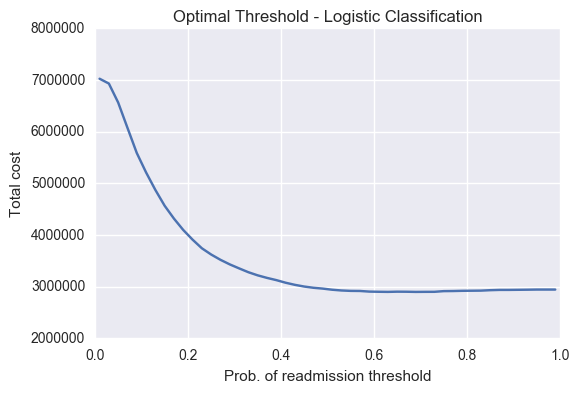

In [302]:
plt.plot(*zip(*best_thresholds))
plt.ylabel('Total cost')
plt.xlabel('Prob. of readmission threshold')
plt.title("Optimal Threshold - Logistic Classification");

In [303]:


min_threshold, min_cost = min(best_thresholds, key=itemgetter(1))

In [304]:
min_threshold

0.69000000000000006

In [305]:
min_cost 

2898442.0343087153

In [306]:
combo_df['new_threshold(.69)_prediction']=combo_df['prob_readmit_logistic']>.69

In [307]:
log_confusion_matrix 

array([[3228,  156],
       [ 689,  309]])

In [308]:
top_threshold_matrix 

array([[3260,  124],
       [ 968,   30]])

In [309]:
top_threshold_matrix = confusion_matrix(tahoe_y, combo_df['new_threshold(.69)_prediction'])

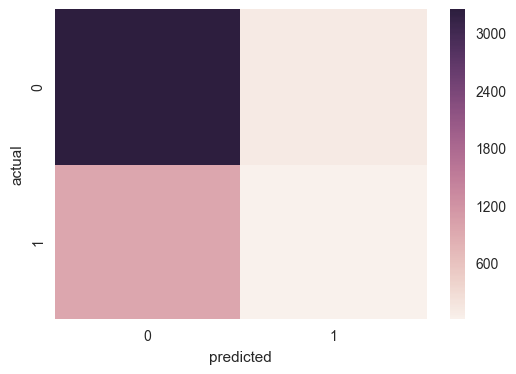

In [310]:
sns.heatmap(top_threshold_matrix);
plt.xlabel("predicted")
plt.ylabel("actual")

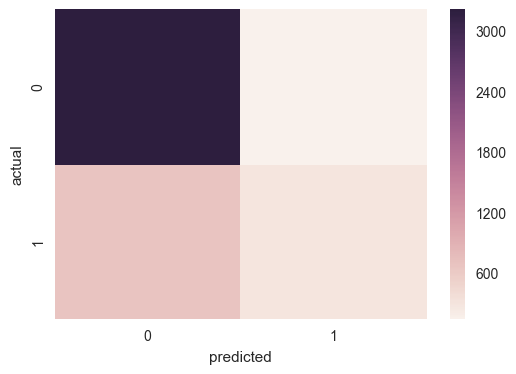

In [311]:
sns.heatmap(log_confusion_matrix);
plt.xlabel("predicted")
plt.ylabel("actual")

- Recalculate the confusion matrix using the best threshold

 - Combine cost curve of managerial and machine learning 